#  Stock Market Prediction using Machine Learning
This notebook implements sentiment analysis and financial feature engineering to predict the S&P 500 market direction using Random Forest and XGBoost classifiers.

In [4]:
#  Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
!pip install newsapi-python
from textblob import TextBlob
from newsapi import NewsApiClient
from tqdm import tqdm
!pip install ta
# Technical analysis library
from ta.volatility import BollingerBands
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator


In [5]:
#  Load S&P 500 data from Yahoo Finance
sp500 = yf.Ticker("^GSPC")
sp500_history = sp500.history(period="max")[["Open", "High", "Low", "Close", "Volume"]]
sp500_history["Tomorrow"] = sp500_history["Close"].shift(-1)
sp500_history["Target"] = (sp500_history["Tomorrow"] > sp500_history["Close"]).astype(int)
sp500_history = sp500_history.loc["1990-01-01":].copy()


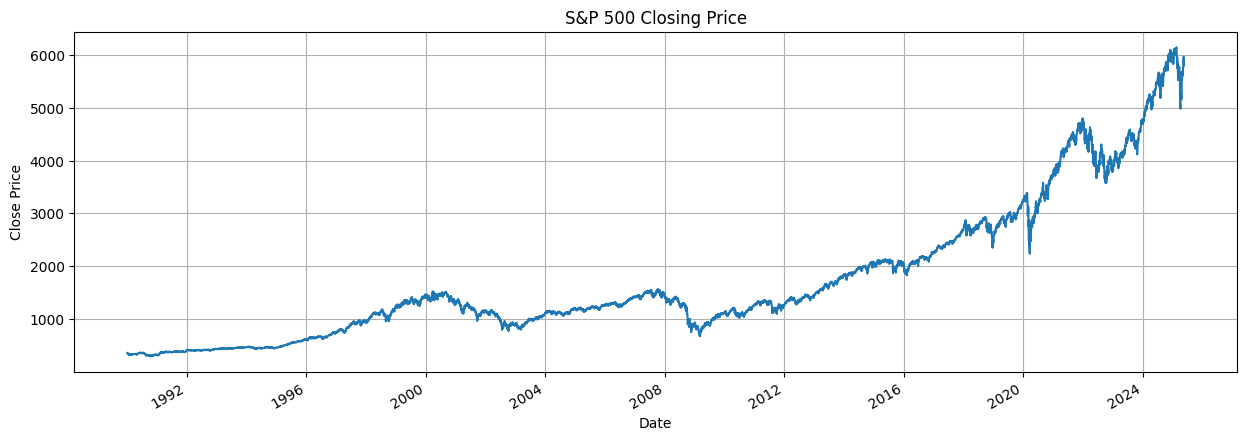

In [6]:
#  Plot closing price over time
sp500_history["Close"].plot(figsize=(15, 5), title="S&P 500 Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


In [7]:
#  Add rolling features
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avg = sp500_history.rolling(horizon).mean()
    sp500_history[f"Close_Ratio_{horizon}"] = sp500_history["Close"] / rolling_avg["Close"]
    sp500_history[f"Trend_{horizon}"] = sp500_history["Target"].shift(1).rolling(horizon).sum()
    new_predictors += [f"Close_Ratio_{horizon}", f"Trend_{horizon}"]

sp500_history.dropna(inplace=True)


In [8]:
#  Random Forest Classifier with probability threshold
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds = (preds >= 0.6).astype(int)
    return pd.DataFrame({
        "Predictions": preds,
        "Target": test["Target"]
    }, index=test.index)

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i]
        test = data.iloc[i:(i+step)]
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [10]:
#  Fetch news sentiment data
newsapi = NewsApiClient(api_key="266e3c81e9a241f6ac2be570f07925fb")  # Replace with your valid NewsAPI key

def fetch_news(date):
    all_articles = newsapi.get_everything(
        q="stock market OR S&P 500 OR finance",
        from_param=date,
        to=date,
        language="en",
        sort_by="relevancy",
        page_size=100
    )
    return [article["title"] for article in all_articles["articles"]]

def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

def get_daily_sentiment(date):
    headlines = fetch_news(date)
    if not headlines:
        return 0
    return sum(get_sentiment_score(headline) for headline in headlines) / len(headlines)

start_date = datetime(2025, 4, 24)
end_date = datetime(2025, 5, 23)
sentiment_data = []

current_date = start_date
while current_date <= end_date:
    sentiment_data.append({
        "Date": current_date,
        "Sentiment": get_daily_sentiment(current_date.strftime("%Y-%m-%d"))
    })
    current_date += timedelta(days=1)

sentiment_df = pd.DataFrame(sentiment_data).set_index("Date")


In [25]:
print(sentiment_df)

            Sentiment
Date                 
2025-04-24   0.064209
2025-04-25   0.129045
2025-04-26   0.105794
2025-04-27   0.118186
2025-04-28   0.094058
2025-04-29   0.092723
2025-04-30   0.061629
2025-05-01   0.081213
2025-05-02   0.164888
2025-05-03   0.047675
2025-05-04   0.202861
2025-05-05   0.064522
2025-05-06   0.150703
2025-05-07   0.099166
2025-05-08   0.077317
2025-05-09   0.109993
2025-05-10   0.060708
2025-05-11   0.180373
2025-05-12   0.065279
2025-05-13   0.051374
2025-05-14   0.109743
2025-05-15   0.102559
2025-05-16   0.107268
2025-05-17   0.106911
2025-05-18   0.084908
2025-05-19   0.070519
2025-05-20   0.039501
2025-05-21   0.038043
2025-05-22   0.053920
2025-05-23   0.092201


In [23]:
#  Merge sentiment scores
sentiment_df.index = sentiment_df.index.tz_localize(None)

sp500_history.index = pd.to_datetime(sp500_history.index)
# Make sp500_history index timezone-naive as well
sp500_history.index = sp500_history.index.tz_localize(None)
# Use join instead of concat to merge based on index
# sp500_history = sp500_history.join(sentiment_df, how="left") # Remove this line as the join was already done

# Ensure the 'Sentiment' column exists after the first join and fill NaNs
# This check is needed in case the previous cell where the first join occurred was not run
if "Sentiment" not in sp500_history.columns:
    sp500_history = sp500_history.join(sentiment_df, how="left")

sp500_history["Sentiment"] = sp500_history["Sentiment"].fillna(0)

# Only append 'Sentiment' to new_predictors if it's not already there
if "Sentiment" not in new_predictors:
    new_predictors.append("Sentiment")

print("New Predictors:", new_predictors)


New Predictors: ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'Sentiment']


In [26]:
#  Add technical indicators
sp500_history["sma_20"] = SMAIndicator(close=sp500_history["Close"], window=20).sma_indicator()
sp500_history["ema_20"] = EMAIndicator(close=sp500_history["Close"], window=20).ema_indicator()
sp500_history["rsi"] = RSIIndicator(close=sp500_history["Close"]).rsi()
sp500_history["macd"] = MACD(close=sp500_history["Close"]).macd()
sp500_history["macd_signal"] = MACD(close=sp500_history["Close"]).macd_signal()
sp500_history["stoch"] = StochasticOscillator(high=sp500_history["High"], low=sp500_history["Low"], close=sp500_history["Close"]).stoch()
bb = BollingerBands(close=sp500_history["Close"])
sp500_history["bollinger_mavg"] = bb.bollinger_mavg()
sp500_history["bollinger_h"] = bb.bollinger_hband()
sp500_history["bollinger_l"] = bb.bollinger_lband()

sp500_history.dropna(inplace=True)
new_predictors += ["sma_20", "ema_20", "rsi", "macd", "macd_signal", "stoch", "bollinger_mavg", "bollinger_h", "bollinger_l"]


In [27]:
#  Run backtest with all features
predictions = backtest(sp500_history, model, new_predictors)
print("Final Backtest Precision:", precision_score(predictions["Target"], predictions["Predictions"]))


Final Backtest Precision: 0.5594795539033457


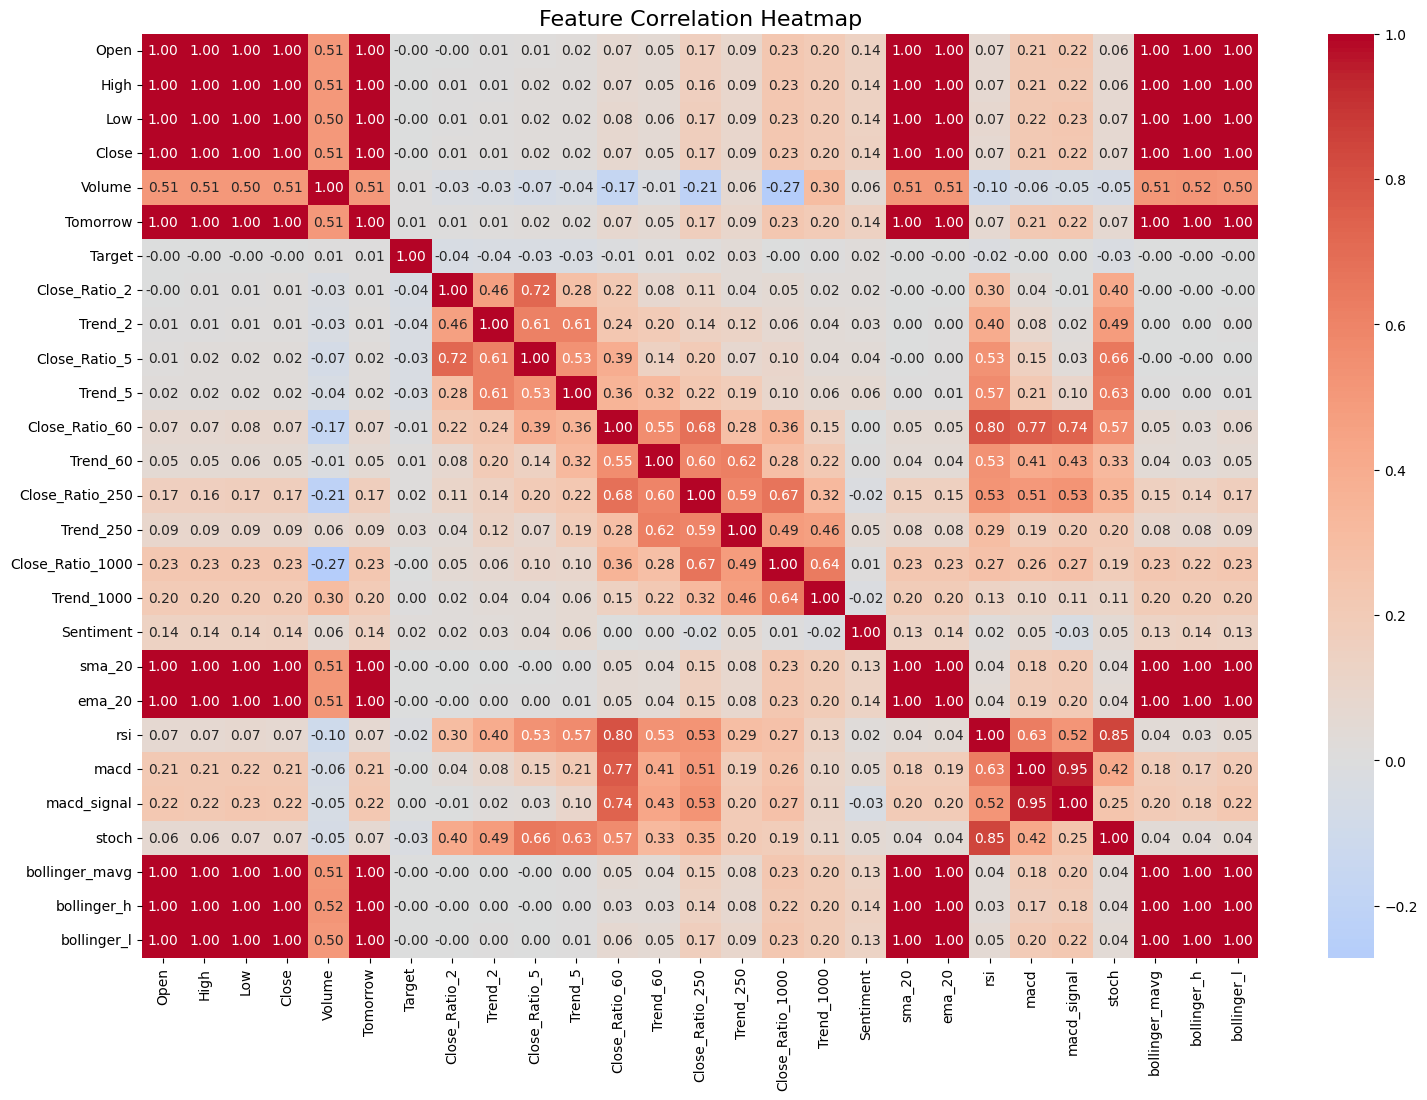

In [28]:
#  Feature correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(sp500_history.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


In [36]:
date_str = "2025-04-24"

if date_str in sp500_history.index:
    row = sp500_history.loc[date_str]
    # Use 'new_predictors' which contains the list of feature names
    features = row[new_predictors].values.reshape(1, -1)
    proba = model.predict_proba(features)[0][1]
    prediction = "Market Up" if proba >= 0.6 else "Market Down"
    print(f"Prediction for {date_str}: {prediction}")
    print(f"Model Confidence: {proba:.2f}")
    # Access the scalar value from the Series before formatting
    print(f"Sentiment Score: {row['Sentiment']}") # .iloc[0] is not needed for a single row Series

else:
    print("Date not available in the dataset.")

Prediction for 2025-04-24: Market Down
Model Confidence: 0.51
Sentiment Score: 0.0642092643607795


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [34]:
from datetime import timedelta

latest_date = sp500_history.index.max()
print(f"Latest available date in the dataset: {latest_date.strftime('%Y-%m-%d')}")

latest_row = sp500_history.loc[latest_date]

latest_features = latest_row[new_predictors].values.reshape(1, -1)

proba = model.predict_proba(latest_features)[0][1]

prediction = "Market Up" if proba >= 0.6 else "Market Down"

print(f"\n Prediction for {latest_date + timedelta(days=1):%Y-%m-%d}")
print(f" Expected Direction: {prediction}")
print(f" Model Confidence: {proba:.2f}")
print(f" Sentiment Score: {latest_row['Sentiment']:.2f}")

Latest available date in the dataset: 2025-05-22

 Prediction for 2025-05-23
 Expected Direction: Market Down
 Model Confidence: 0.54
 Sentiment Score: 0.05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
